<a href="https://colab.research.google.com/github/ayla011/diabetes_prediction_model/blob/main/Who's_at_Risk_of_Diabetes%3F_(with_Prediction_Model)_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = '100000-diabetes-clinical-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5420190%2F8998172%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240818%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240818T113554Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D18a6fcbd57f605ecdcd0485f2089b82e45d7c5025bf01ab95a2d8c4ee9dd42949178e60009fafb6af640493410a3ecd44968582021e536c5e4986596f416eab8f8f4726b4d9e463dae5df911518f3c60d3a718e75d8fe382cfc1c8c241cb8b9e0331454bd9b5e7a53d239a0e14e9a38449cab1ccc71b50000176f500a09bf115f14dd3914ef0113177e2a57cdd2aa0cf6def2c2610249fce00010edd7b10a1049ed6a33029ede1006086dbfdd8b712170de4d5a69a59f2e46bb3414df2cf3bed7d2affc8aa8a6c36e3a9c8a281609945c656f1d1de9a50046ddacdae40aeafc41d0022cdc5e84f2c6d8a3a53c5856d542a3f463b9a2501d6e07197cea70ca7ad'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 917848 bytes downloaded
Downloaded and uncompressed: 100000-diabetes-clinical-dataset
Data source import complete.


# Importing Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, mannwhitneyu, chi2_contingency, chi2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Inspecting the Dataset

In [ ]:
df = pd.read_csv("/kaggle/input/100000-diabetes-clinical-dataset/diabetes_dataset.csv")

In [ ]:
df.head()

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  100000 non-null  int64  
 1   gender                100000 non-null  object 
 2   age                   100000 non-null  float64
 3   location              100000 non-null  object 
 4   race:AfricanAmerican  100000 non-null  int64  
 5   race:Asian            100000 non-null  int64  
 6   race:Caucasian        100000 non-null  int64  
 7   race:Hispanic         100000 non-null  int64  
 8   race:Other            100000 non-null  int64  
 9   hypertension          100000 non-null  int64  
 10  heart_disease         100000 non-null  int64  
 11  smoking_history       100000 non-null  object 
 12  bmi                   100000 non-null  float64
 13  hbA1c_level           100000 non-null  float64
 14  blood_glucose_level   100000 non-null  int64  
 15  d

In [ ]:
df.describe()

,year,age,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2018.360820,41.885856,0.202230,0.200150,0.198760,0.19888,0.199980,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,1.345239,22.516840,0.401665,0.400114,0.399069,0.39916,0.399987,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,2015.000000,0.080000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,2019.000000,24.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,2019.000000,43.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,2019.000000,60.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,2022.000000,80.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


# Balancing and Cleaning the Dataset

<ipython-input-70-c091020b8017>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  d.set_xticklabels(["Non-Diabetic", "Diabetic"])


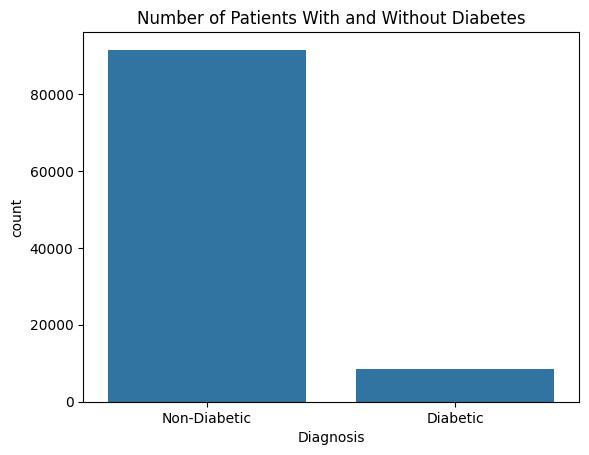

In [ ]:
d = sns.countplot(data = df, x = "diabetes")
d.set_title("Number of Patients With and Without Diabetes")
d.set_xlabel("Diagnosis")
d.set_xticklabels(["Non-Diabetic", "Diabetic"])
plt.show()

In [ ]:
df_race = df[["race:AfricanAmerican", "race:Asian", "race:Caucasian", "race:Hispanic", "race:Other"]]
by_race = pd.from_dummies(df_race)
df2 = df.drop(columns = ["race:AfricanAmerican", "race:Asian", "race:Caucasian", "race:Hispanic", "race:Other"])
df2.insert(2, "race", by_race)
df2["race"] = df2["race"].str.replace("race:", "")
df2["race"] = df2["race"].str.replace("AfricanAmerican", "African-American")

In [ ]:
bins = [0, 18, 25, 35, 45, 55, 65, np.inf]
age_order = ["0-18", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]
df2.insert(3, "age_cat", pd.cut(df2["age"], bins, labels = age_order))

In [ ]:
bins = [0, 18.5, 25, 30, 35, 40, np.inf]
bmi_order = ["Underweight", "Normal", "Overweight", "Moderately Obese", "Severely Obese", "Morbidly Obese"]
df2.insert(9, "bmi_cat", pd.cut(df2["bmi"], bins, labels = bmi_order))

In [ ]:
df2["smoking_history"] = df2["smoking_history"].str.title()
df2 = df2[df2["smoking_history"] != "No Info"]

In [ ]:
columns = ['gender', 'race', 'age_cat', 'location', 'hypertension','heart_disease', 'smoking_history', 'bmi_cat', 'diabetes']

for col in columns:

    if col in ['gender', 'race', 'age_cat', 'location', 'smoking_history', 'bmi_cat']:
        df2[col] = df2[col].astype("category")

    else:
        df2[col] = df2[col].astype("bool")

<ipython-input-75-cdd1d3cfd9cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col] = df2[col].astype("category")
<ipython-input-75-cdd1d3cfd9cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col] = df2[col].astype("category")
<ipython-input-75-cdd1d3cfd9cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [ ]:
columns = list(df2.columns)
new_name = [col.title() for col in columns]

for c, n in zip(columns, new_name):
    df2 = df2.rename(columns = {c:n})

df2 = df2.rename(columns = {"Age_Cat":"Age Group",
                            "Heart_Disease":"Heart Disease",
                            "Smoking_History":"Smoking History",
                            "Bmi_Cat":"BMI Category",
                            "Bmi":"BMI",
                            "Hba1C_Level":"HbA1C Level",
                            "Blood_Glucose_Level":"Blood Glucose Level"
                           }
                )
df2.head()

,Year,Gender,Race,Age Group,Age,Location,Hypertension,Heart Disease,Smoking History,BMI Category,BMI,HbA1C Level,Blood Glucose Level,Diabetes
0,2020,Female,Other,25-34,32.0,Alabama,False,False,Never,Overweight,27.32,5.0,100,False
1,2015,Female,Asian,25-34,29.0,Alabama,False,False,Never,Normal,19.95,5.0,90,False
2,2015,Male,Other,0-18,18.0,Alabama,False,False,Never,Normal,23.76,4.8,160,False
3,2015,Male,Caucasian,35-44,41.0,Alabama,False,False,Never,Overweight,27.32,4.0,159,False
4,2016,Female,African-American,45-54,52.0,Alabama,False,False,Never,Normal,23.75,6.5,90,False


In [ ]:
diabetes_yes = df2[df2["Diabetes"] == True]
diabetes_no = df2[df2["Diabetes"] == False].sample(n = diabetes_yes.shape[0], ignore_index = True, random_state = 42)

sample = pd.concat([diabetes_yes, diabetes_no], axis = 0).reset_index(drop = True)

sample.head()

,Year,Gender,Race,Age Group,Age,Location,Hypertension,Heart Disease,Smoking History,BMI Category,BMI,HbA1C Level,Blood Glucose Level,Diabetes
0,2016,Female,Other,55-64,64.0,Alabama,False,False,Ever,Morbidly Obese,49.27,8.2,140,True
1,2016,Male,African-American,65+,80.0,Alabama,False,False,Former,Overweight,29.16,8.8,140,True
2,2016,Female,Other,35-44,42.0,Alabama,False,False,Current,Overweight,27.32,7.5,130,True
3,2016,Female,Hispanic,65+,80.0,Alabama,False,True,Never,Overweight,26.00,7.5,200,True
4,2015,Female,Caucasian,65+,79.0,Alabama,False,False,Never,Moderately Obese,30.84,5.8,220,True


<ipython-input-78-b5a2d8a5ffe3>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  d.set_xticklabels(["Non-Diabetic", "Diabetic"])


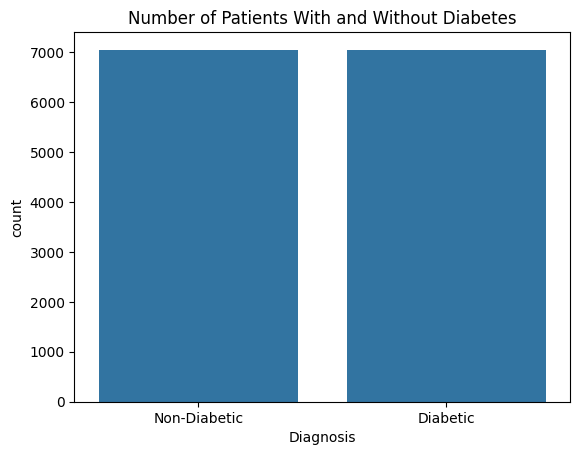

In [ ]:
d = sns.countplot(data = sample, x = "Diabetes")
d.set_title("Number of Patients With and Without Diabetes")
d.set_xlabel("Diagnosis")
d.set_xticklabels(["Non-Diabetic", "Diabetic"])
plt.show()

In [ ]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14092 entries, 0 to 14091
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Year                 14092 non-null  int64   
 1   Gender               14092 non-null  category
 2   Race                 14092 non-null  category
 3   Age Group            14092 non-null  category
 4   Age                  14092 non-null  float64 
 5   Location             14092 non-null  category
 6   Hypertension         14092 non-null  bool    
 7   Heart Disease        14092 non-null  bool    
 8   Smoking History      14092 non-null  category
 9   BMI Category         14092 non-null  category
 10  BMI                  14092 non-null  float64 
 11  HbA1C Level          14092 non-null  float64 
 12  Blood Glucose Level  14092 non-null  int64   
 13  Diabetes             14092 non-null  bool    
dtypes: bool(3), category(6), float64(3), int64(2)
memory usage: 678.0 KB


# Exploratory Data Analysis

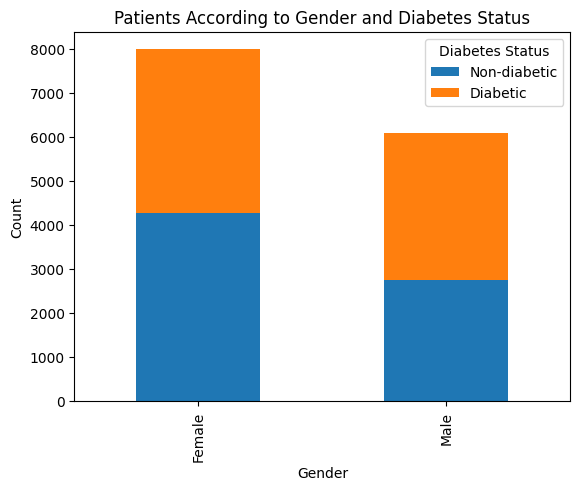

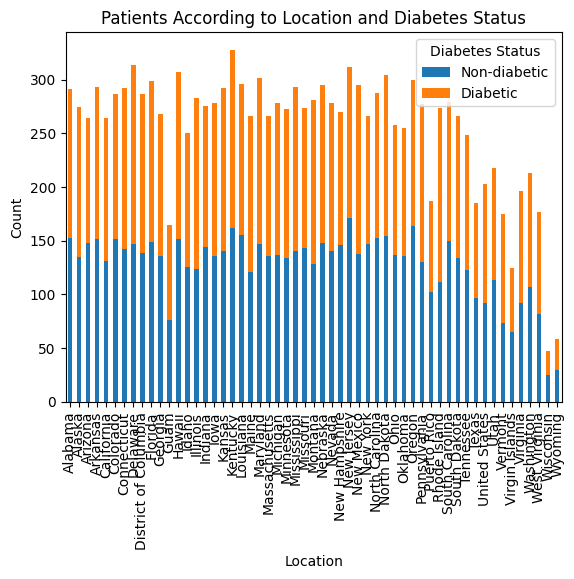

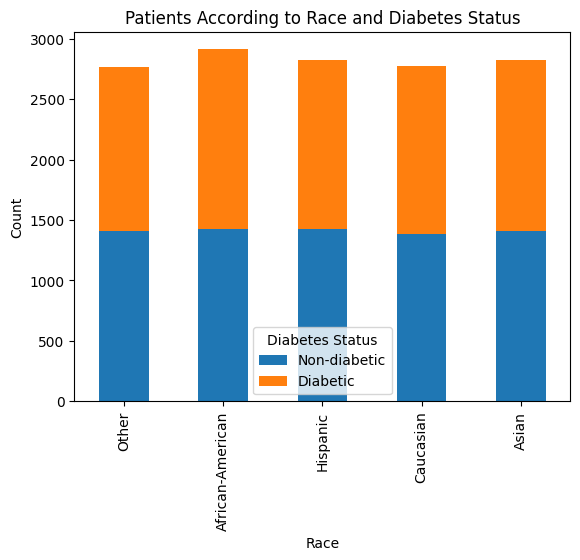

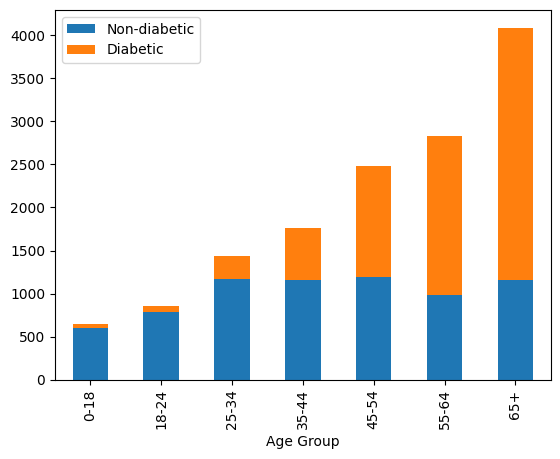

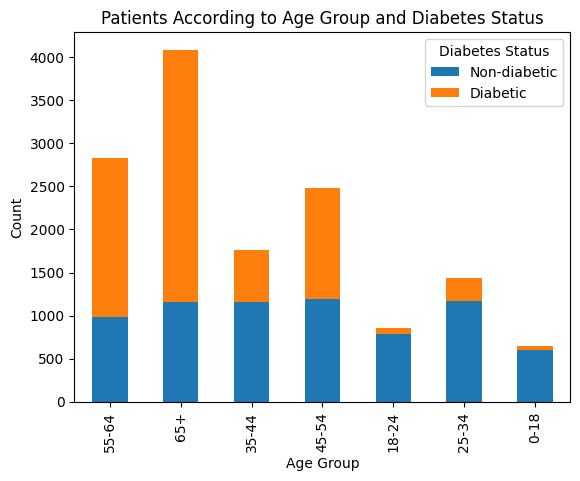

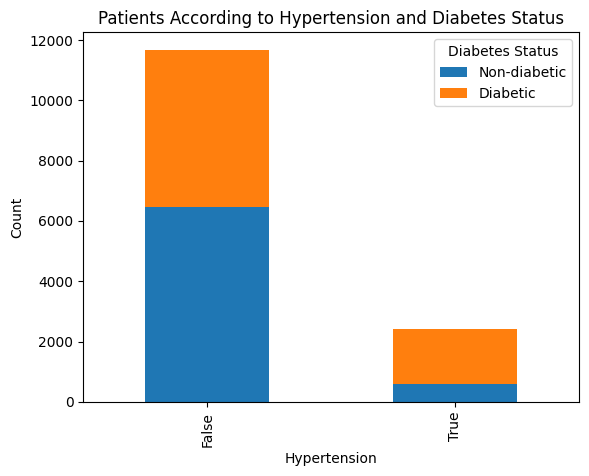

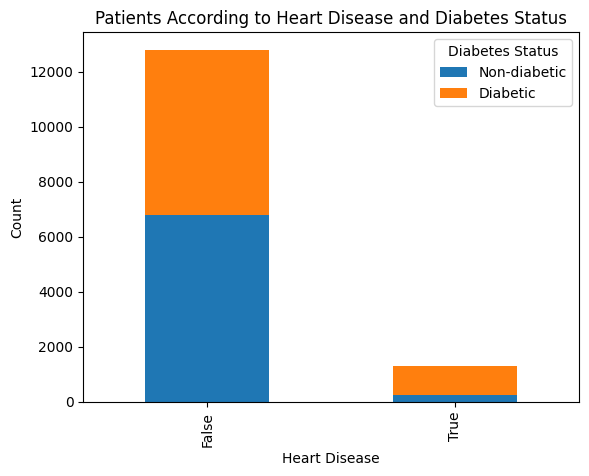

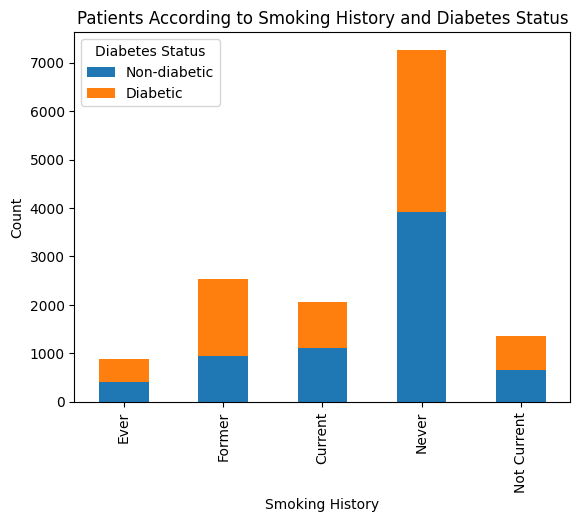

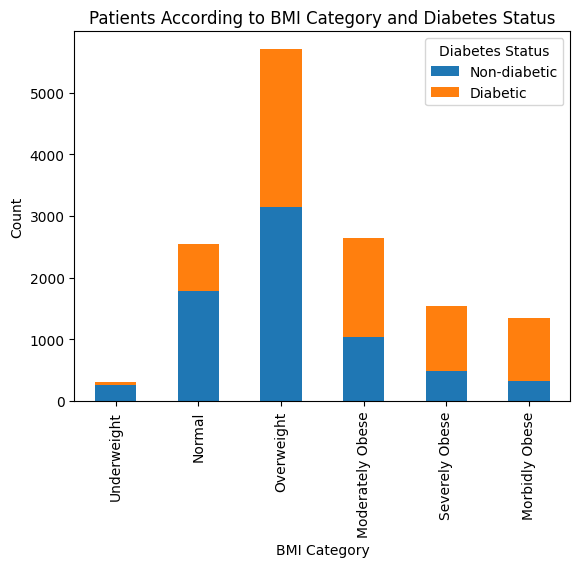

In [ ]:
cat_columns = ["Gender",
               "Location",
               "Race",
               "Age Group",
               "Hypertension",
               "Heart Disease",
               "Smoking History",
               "BMI Category"]

for col in cat_columns:

    categories = list(sample[col].unique())

    non_diabetic_counts = []
    diabetic_counts = []

    for cat in categories:

        non_diabetic = sample[(sample[col] == cat) & (sample["Diabetes"] == False)].shape[0]
        diabetic = sample[(sample[col] == cat) & (sample["Diabetes"] == True)].shape[0]

        non_diabetic_counts.append(non_diabetic)
        diabetic_counts.append(diabetic)

    d = pd.DataFrame({col: categories, "Non-diabetic": non_diabetic_counts, "Diabetic": diabetic_counts})

    if col == "Age Group":
        d[col] = pd.Categorical(d[col], categories = age_order, ordered=True)
        d_sorted = d.sort_values(col)
        d_sorted.plot(x = col, kind = "bar", stacked = True)

    if col == "BMI Category":
        d[col] = pd.Categorical(d[col], categories = bmi_order, ordered=True)
        d_sorted = d.sort_values(col)
        d_sorted.plot(x = col, kind = "bar", stacked = True)

    else:
        d.plot(x = col, kind = "bar", stacked = True)

    plt.title(f"Patients According to {col} and Diabetes Status")
    plt.xlabel(f"{col}")
    plt.ylabel("Count")
    plt.legend(title = "Diabetes Status")
    plt.show()



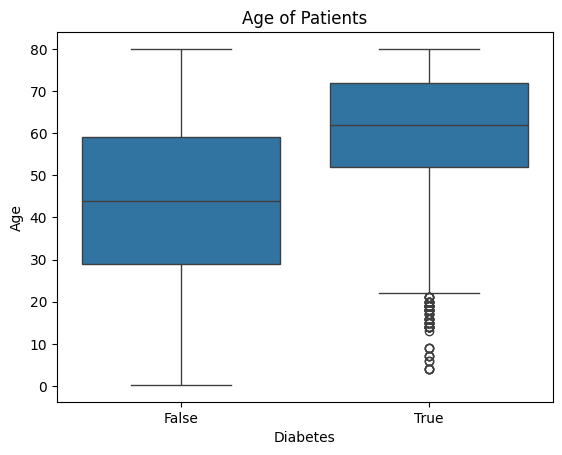

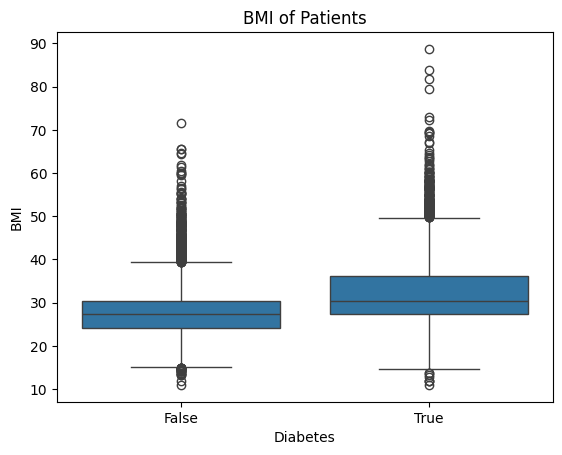

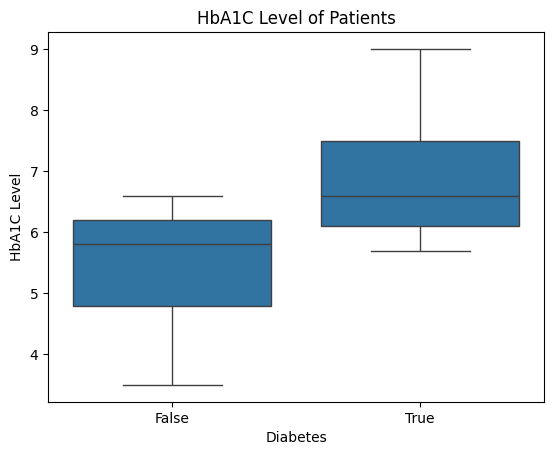

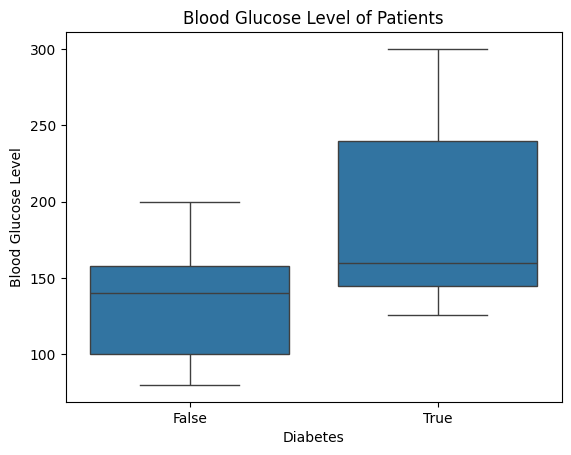

In [ ]:
num_columns = ["Age", "BMI", "HbA1C Level", "Blood Glucose Level"]

for col in num_columns:
    n = sns.boxplot(data = sample, x = "Diabetes", y = col)
    n.set_title(f"{col} of Patients")
    plt.show()

# Correlation Matrix

In [ ]:
df_encoded = sample.drop(columns = ["Age Group", "BMI Category"])
le = LabelEncoder()

df_encoded["Gender"] = le.fit_transform(df_encoded["Gender"])
df_encoded["Location"] = le.fit_transform(df_encoded["Location"])
df_encoded["Race"] = le.fit_transform(df_encoded["Race"])
df_encoded["Smoking History"] = le.fit_transform(df_encoded["Smoking History"])
df_encoded

,Year,Gender,Race,Age,Location,Hypertension,Heart Disease,Smoking History,BMI,HbA1C Level,Blood Glucose Level,Diabetes
0,2016,0,4,64.0,0,False,False,1,49.27,8.2,140,True
1,2016,1,0,80.0,0,False,False,2,29.16,8.8,140,True
2,2016,0,4,42.0,0,False,False,0,27.32,7.5,130,True
3,2016,0,3,80.0,0,False,True,3,26.00,7.5,200,True
4,2015,0,2,79.0,0,False,False,3,30.84,5.8,220,True
...,...,...,...,...,...,...,...,...,...,...,...,...
14087,2015,0,0,65.0,2,False,False,3,35.71,4.8,130,False
14088,2019,1,4,34.0,14,False,False,3,30.79,6.2,159,False
14089,2019,1,1,62.0,42,False,False,4,28.99,5.0,126,False
14090,2015,0,4,58.0,26,True,False,2,38.88,6.1,159,False


In [ ]:
corr_mat = df_encoded.corr()
corr_mat

,Year,Gender,Race,Age,Location,Hypertension,Heart Disease,Smoking History,BMI,HbA1C Level,Blood Glucose Level,Diabetes
Year,1.000000,-0.011835,0.003297,-0.010562,-0.071358,-0.002240,0.006660,-0.001844,-0.006548,-0.011526,0.004533,-0.009179
Gender,-0.011835,1.000000,0.007247,0.040211,-0.000098,0.033014,0.097248,-0.100240,-0.017178,0.057054,0.053412,0.082347
Race,0.003297,0.007247,1.000000,-0.002545,0.005630,0.004864,-0.007108,-0.019484,-0.003705,-0.000954,0.006093,-0.012861
Age,-0.010562,0.040211,-0.002545,1.000000,0.010560,0.241907,0.253331,0.011020,0.128023,0.266674,0.233665,0.442779
Location,-0.071358,-0.000098,0.005630,0.010560,1.000000,0.003679,-0.001950,0.001268,0.008082,0.002718,0.000913,0.002039
Hypertension,-0.002240,0.033014,0.004864,0.241907,0.003679,1.000000,0.098031,-0.005459,0.138493,0.142238,0.122331,0.235572
Heart Disease,0.006660,0.097248,-0.007108,0.253331,-0.001950,0.098031,1.000000,-0.046557,0.028540,0.118840,0.111756,0.199989
Smoking History,-0.001844,-0.100240,-0.019484,0.011020,0.001268,-0.005459,-0.046557,1.000000,-0.008508,-0.012374,-0.015215,-0.015849
BMI,-0.006548,-0.017178,-0.003705,0.128023,0.008082,0.138493,0.028540,-0.008508,1.000000,0.168636,0.159945,0.295883
HbA1C Level,-0.011526,0.057054,-0.000954,0.266674,0.002718,0.142238,0.118840,-0.012374,0.168636,1.000000,0.315793,0.599497


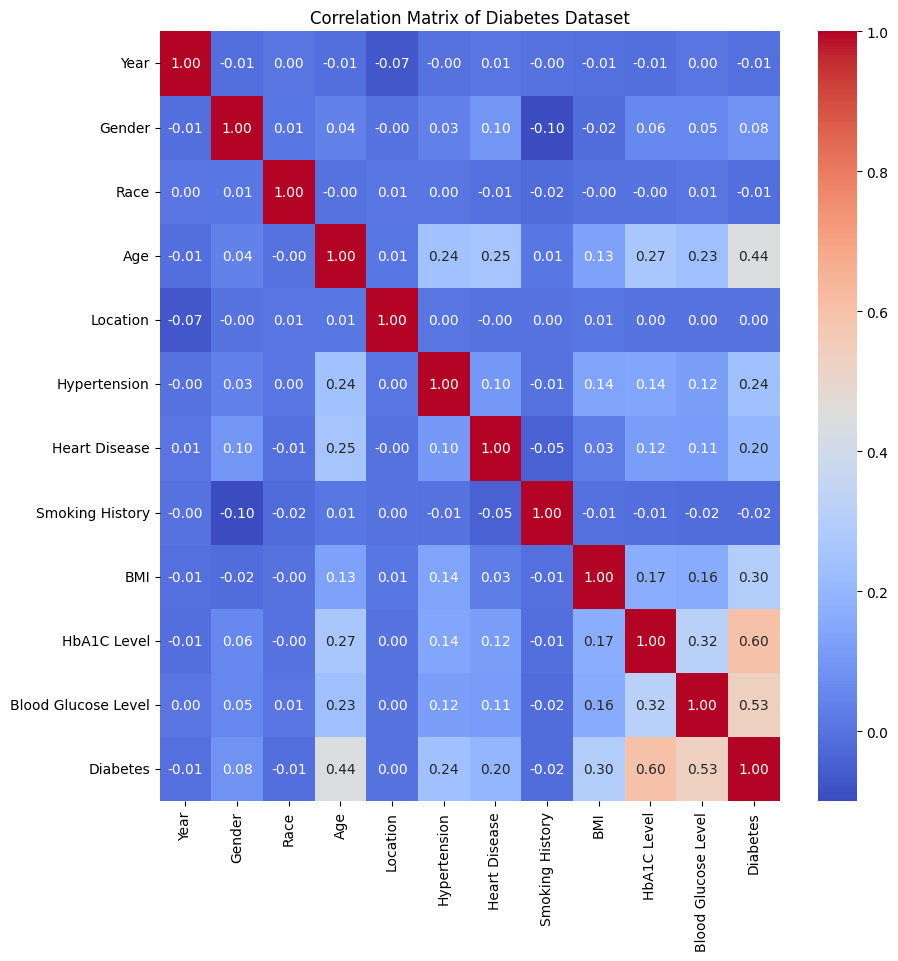

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr_mat, annot = True, cmap = "coolwarm", fmt='.2f')
plt.title("Correlation Matrix of Diabetes Dataset")
plt.show()

# Drill-down Analysis

<ipython-input-85-a40c221c6d39>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  c.set_xticklabels(["Non-Diabetic", "Diabetic"])


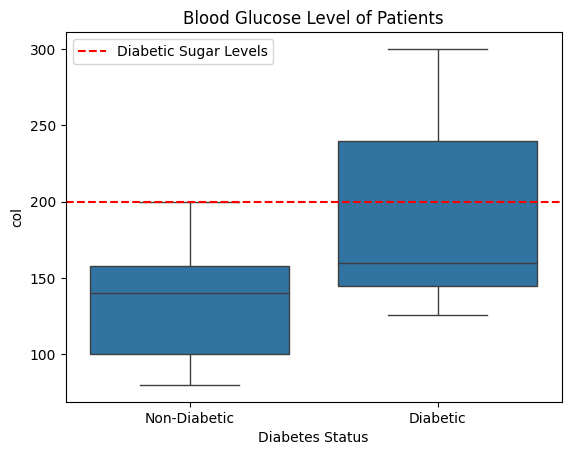

<ipython-input-85-a40c221c6d39>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  c.set_xticklabels(["Non-Diabetic", "Diabetic"])


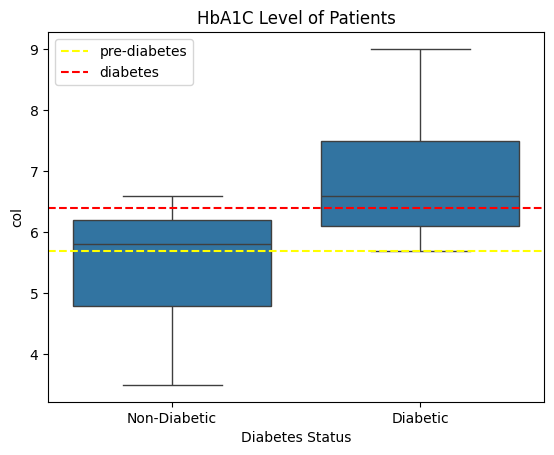

In [ ]:
columns =  ["Blood Glucose Level", "HbA1C Level"]

for col in columns:

    c = sns.boxplot(data = sample, x = "Diabetes", y = col)
    c.set_title(f"{col} of Patients")
    c.set_xlabel("Diabetes Status")
    c.set_ylabel(f"col")
    c.set_xticklabels(["Non-Diabetic", "Diabetic"])

    if col == "Blood Glucose Level":
        c.axhline(y = 200, c = "red", ls = "--", label = "Diabetic Sugar Levels")

    else:
        c.axhline(y = 5.7, c = "yellow", ls = "--",label = "pre-diabetes")
        c.axhline(y = 6.4, c = "red", ls = "--",label = "diabetes")

    c.legend()
    plt.show()

In [ ]:
columns =  ["Blood Glucose Level", "HbA1C Level"]

for col in columns:

    Nondiabetic = sample[sample["Diabetes"] == 0][col]
    Diabetic = sample[sample["Diabetes"] == 1][col]
    data = [Nondiabetic, Diabetic]

    for d in data:
        stats, pval = shapiro(d)

        if pval <= 0.05:
            print(f"The distribution of {col} is not normal.")

        else:
            print(f"The distribution of {col} is normal.")

The distribution of Blood Glucose Level is not normal.
The distribution of Blood Glucose Level is not normal.
The distribution of HbA1C Level is not normal.
The distribution of HbA1C Level is not normal.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7046.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
columns =  ["Blood Glucose Level", "HbA1C Level"]

for col in columns:

    stat, pval = mannwhitneyu(
        sample[sample["Diabetes"] == 1][col],
        sample[sample["Diabetes"] == 0][col], alternative = "greater")

    if pval > 0.05:
        print(f"p-value = {pval}. The {col} of patients with diabetes are not higher than those with diabetes.")

    else:
        print(f"p-value = {pval}. The {col} of patients with diabetes are higher than those with diabetes.")

p-value = 0.0. The Blood Glucose Level of patients with diabetes are higher than those with diabetes.
p-value = 0.0. The HbA1C Level of patients with diabetes are higher than those with diabetes.


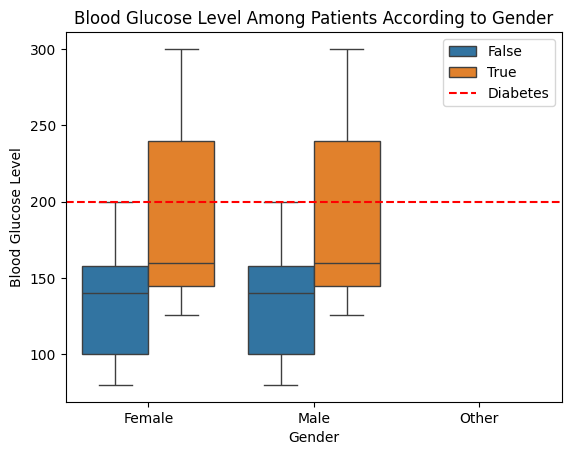

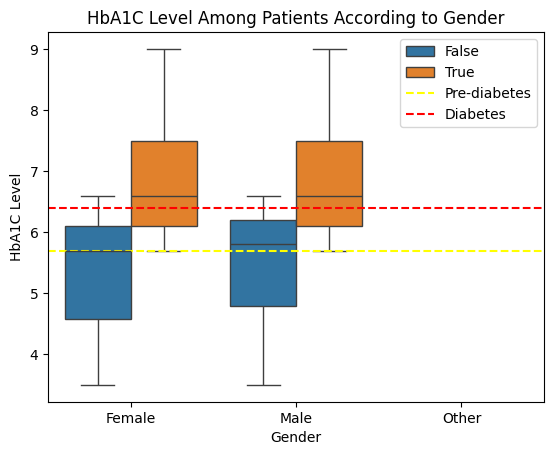

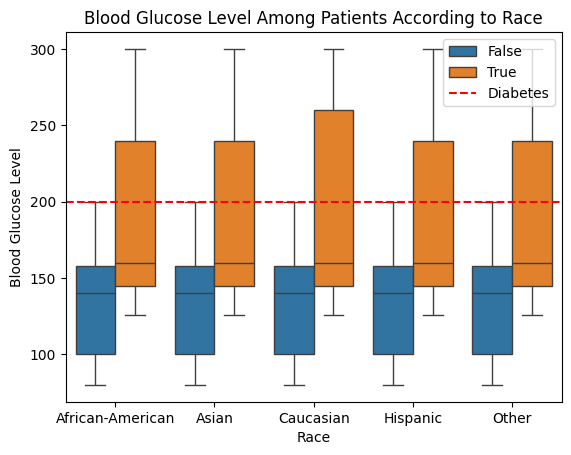

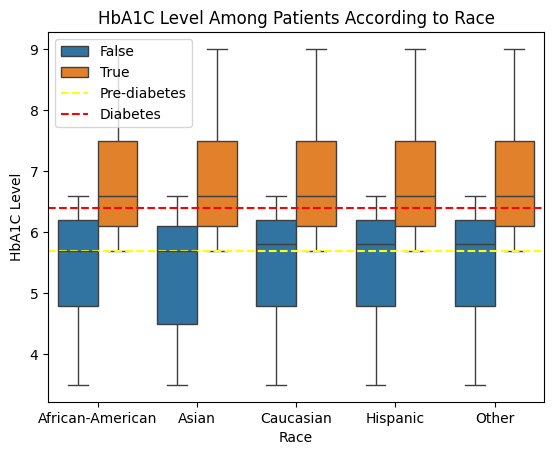

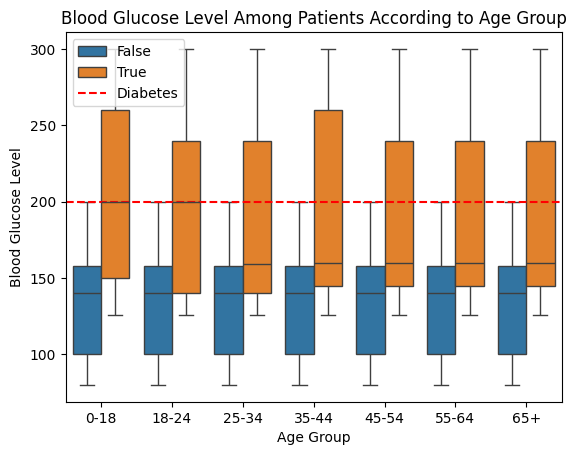

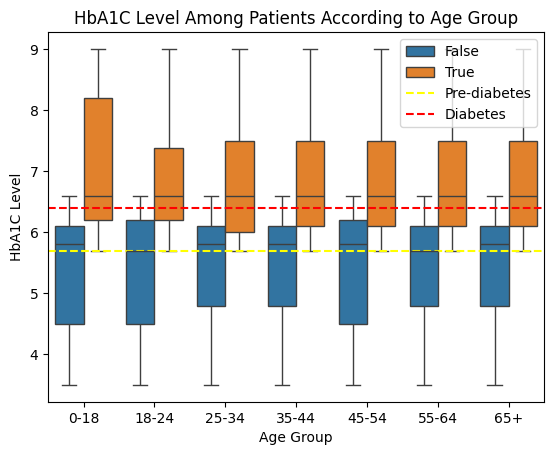

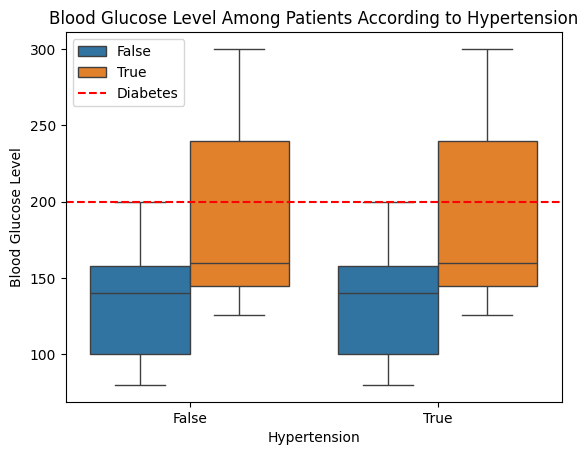

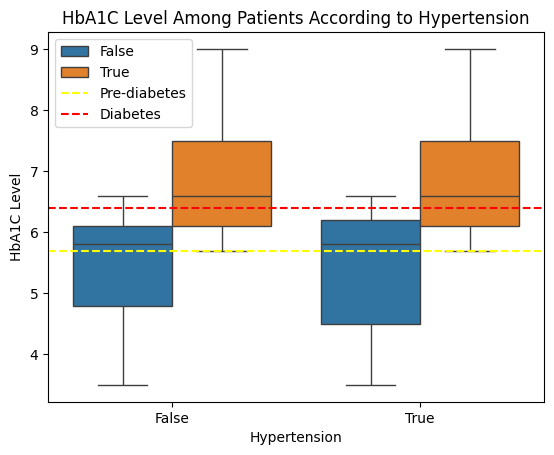

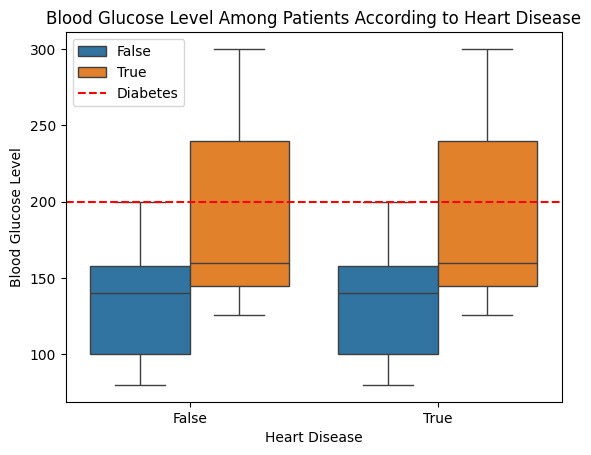

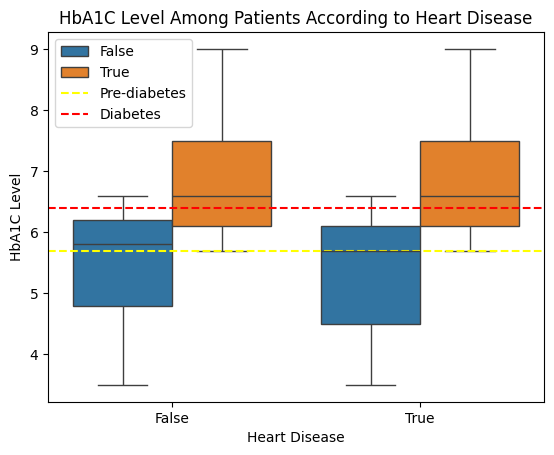

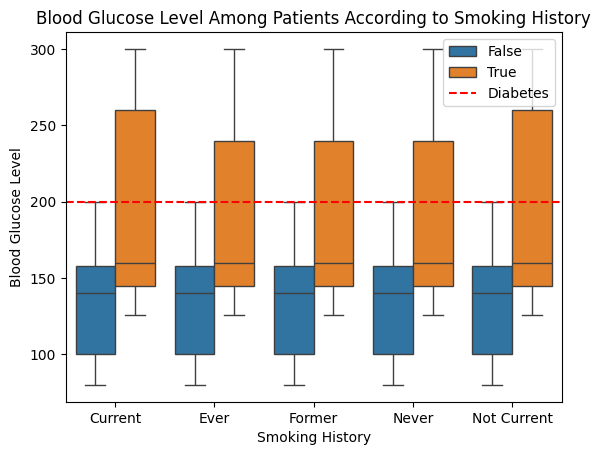

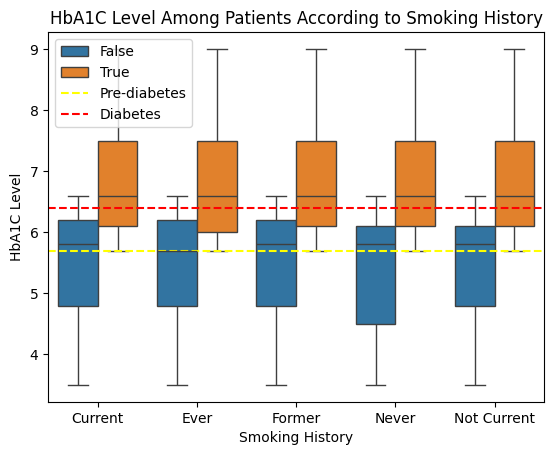

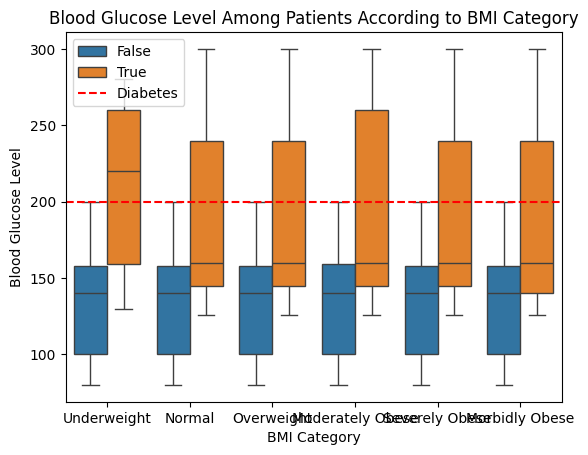

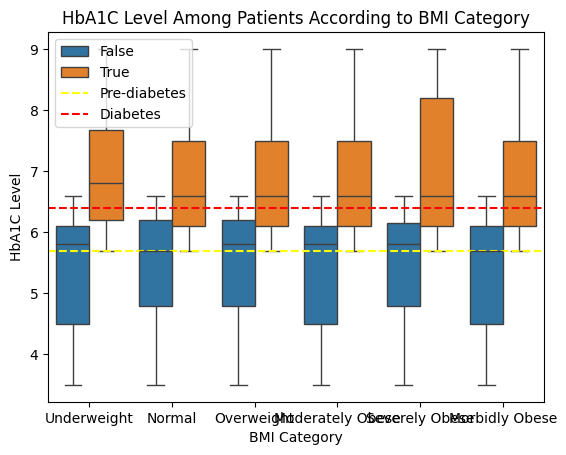

In [ ]:
targets = ["Blood Glucose Level", "HbA1C Level"]
cat_columns.remove("Location")

for col in cat_columns:

    for target in targets:
        h = sns.boxplot(data = sample, x = col, y = target, hue = "Diabetes")
        h.set_title(f"{target} Among Patients According to {col}")
        h.set_xlabel(f"{col}")
        h.set_ylabel(f"{target}")

        if target == "Blood Glucose Level":
            h.axhline(y = 200, c = "red", ls = "--",label = "Diabetes")

        else:
            h.axhline(y = 5.7, c = "yellow", ls = "--",label = "Pre-diabetes")
            h.axhline(y = 6.4, c = "red", ls = "--",label = "Diabetes")

        h.legend()
        plt.show()

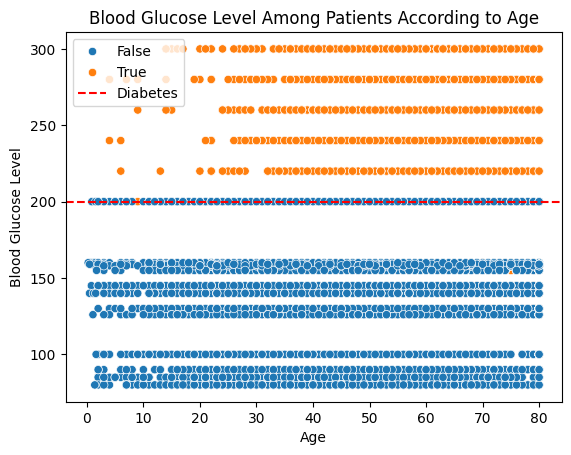

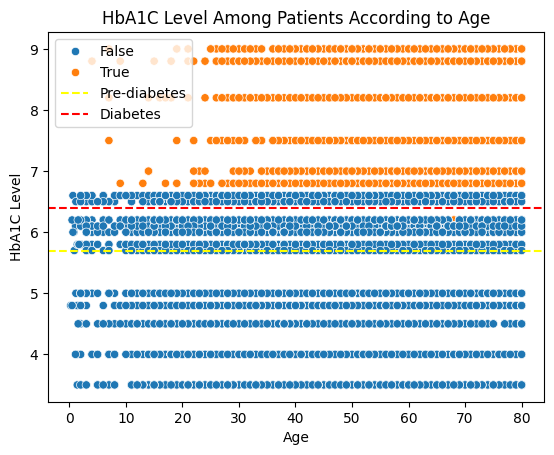

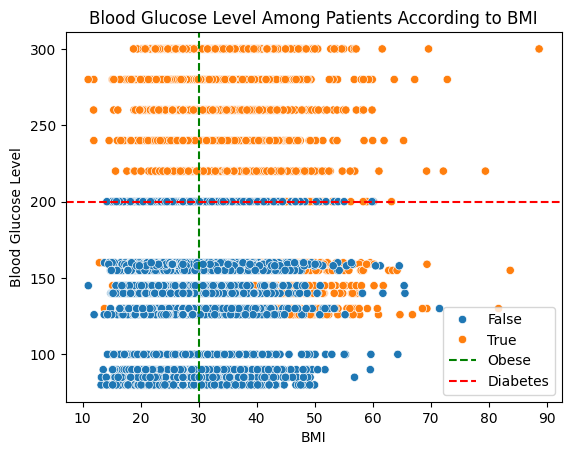

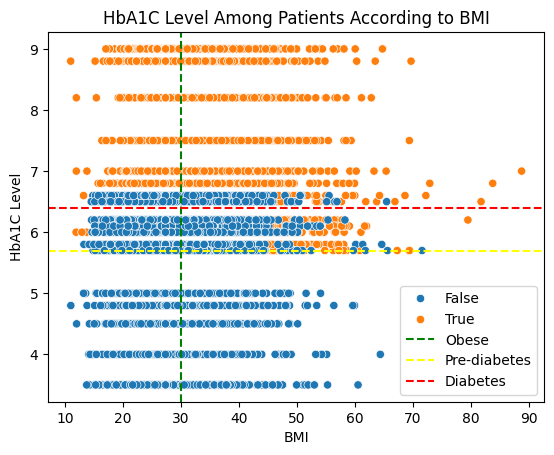

In [ ]:
columns = ["Age", "BMI"]
targets = ["Blood Glucose Level", "HbA1C Level"]

for col in columns:

    for target in targets:

        h = sns.scatterplot(data = sample, x = col, y = target, hue = "Diabetes")
        h.set_title(f"{target} Among Patients According to {col}")

        if col == "BMI":
            h.axvline(x = 30, c = "green", ls = "--",label = "Obese")

        h.set_xlabel(f"{col}")
        h.set_ylabel(f"{target}")

        if target == "Blood Glucose Level":
            h.axhline(y = 200, c = "red", ls = "--",label = "Diabetes")

        else:
            h.axhline(y = 5.7, c = "yellow", ls = "--",label = "Pre-diabetes")
            h.axhline(y = 6.4, c = "red", ls = "--",label = "Diabetes")

        h.legend()
        plt.show()

# Statistical Tests for Relationship/Independence

In [ ]:
cat_columns.append("Location")

for col in cat_columns:
    contingency_table  = pd.crosstab(sample[col], sample["Diabetes"])
    chi_square, p, dof, expected = chi2_contingency(contingency_table)
    critical_value = chi2.ppf(1 - 0.05, dof)

    if chi_square <= critical_value:
        print(f"There is no relationship between {col} and diabetes.")
        cat_columns.remove(col)

    else:
        print(f"There is a relationship between {col} and diabetes.")

There is a relationship between Gender and diabetes.
There is no relationship between Race and diabetes.
There is a relationship between Hypertension and diabetes.
There is a relationship between Heart Disease and diabetes.
There is a relationship between Smoking History and diabetes.
There is a relationship between BMI Category and diabetes.
There is no relationship between Location and diabetes.


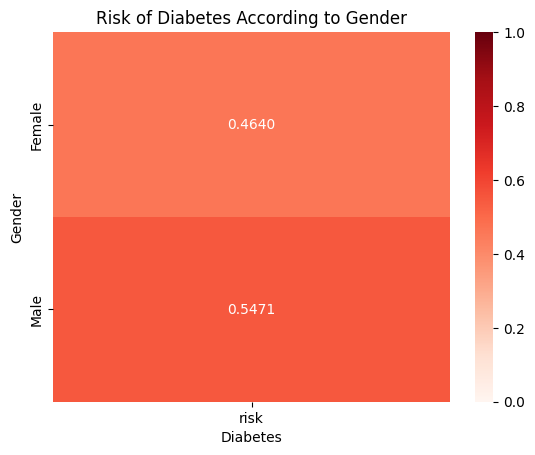

Male: 1.18 times more likely to develop diabetes.


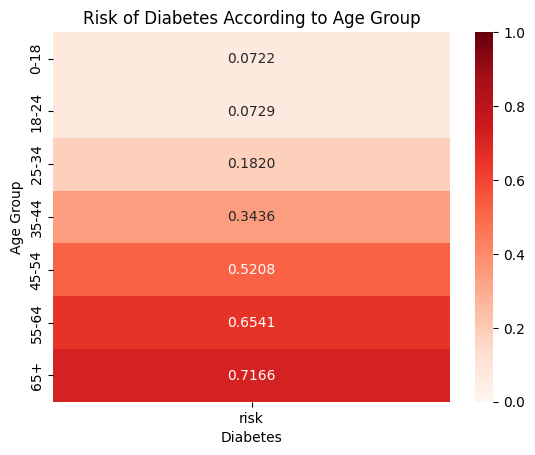

Ages 65+: 2.33 times more likely to develop diabetes.


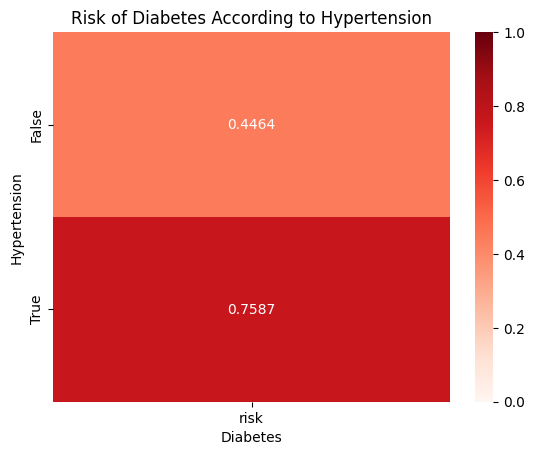

People with Hypertension: 1.7 times more likely to develop diabetes.


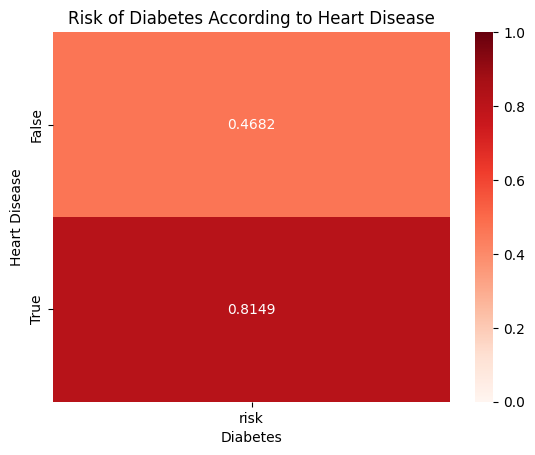

People with Heart Disease: 1.74 times more likely to develop diabetes.


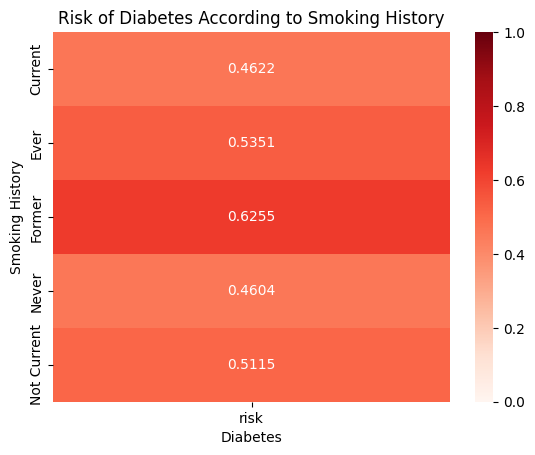

Former smokers: 1.27 times more likely to develop diabetes.


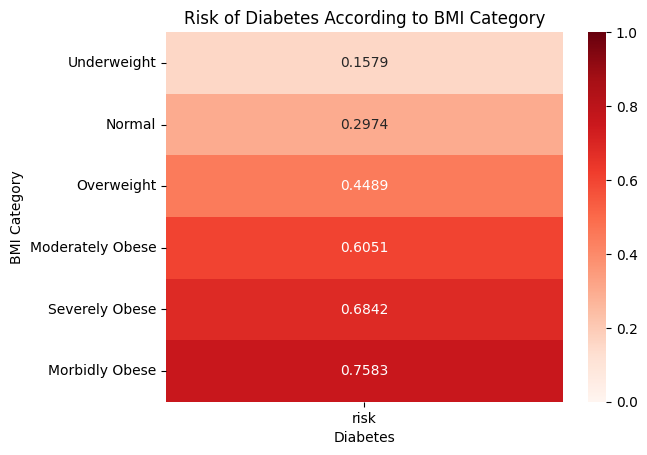

Morbidly Obese people: 1.73 times more likely to develop diabetes.


In [ ]:
for col in cat_columns:

    contingency_table  = pd.crosstab(sample[col], sample["Diabetes"])
    contingency_table["total"] = contingency_table[False] + contingency_table[True]
    contingency_table["risk"] = contingency_table[True] / contingency_table["total"]
    risk_A_label = contingency_table["risk"].idxmax()
    risk_A = contingency_table.loc[risk_A_label, "risk"]
    risk_B = contingency_table.loc[contingency_table.index != risk_A_label, "risk"].mean()
    rr = round(risk_A/risk_B, 2)

    sns.heatmap(contingency_table.drop(columns = [True, False, "total"]), vmin = 0, vmax = 1, annot = True, cmap = "Reds", fmt = ".4f")
    plt.title(f"Risk of Diabetes According to {col}")
    plt.show()

    if col == "Age Group":
        print(f"Ages {risk_A_label}: {rr} times more likely to develop diabetes.")

    elif col in ["Hypertension", "Heart Disease"]:
        if risk_A_label == True:
            print(f"People with {col}: {rr} times more likely to develop diabetes.")
        else:
            print(f"People without {col}: {rr} times more likely to develop diabetes.")

    elif col == "Smoking History":
        print(f"{risk_A_label} smokers: {rr} times more likely to develop diabetes.")

    elif col == "BMI Category":
        print(f"{risk_A_label} people: {rr} times more likely to develop diabetes.")

    else:
        print(f"{risk_A_label}: {rr} times more likely to develop diabetes.")

# Prediction Model

## Data Preprocessing

In [ ]:
df2 = pd.get_dummies(data = df2, columns = ["Gender", "Race", "Location", "Smoking History"], drop_first = True)

X = df2.drop(columns = ["Year", "Age Group", "Diabetes", "BMI Category"])
y = df2["Diabetes"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
scaler_X = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

## Logistic Regression

In [ ]:
logit = LogisticRegression()
logit.fit(X_train_scaled, y_train)
y_logit = logit.predict(X_test_scaled)
acc_logit = accuracy_score(y_logit, y_test)
class_rep_logit = classification_report(y_logit, y_test)
print("accuracy: ", acc_logit)
print(class_rep_logit)




accuracy:  0.947261821297811
              precision    recall  f1-score   support

       False       0.99      0.95      0.97     11800
        True       0.63      0.87      0.73      1037

    accuracy                           0.95     12837
   macro avg       0.81      0.91      0.85     12837
weighted avg       0.96      0.95      0.95     12837



## Decision Tree

In [ ]:
tree = DecisionTreeClassifier(random_state = 42)
tree.fit(X_train_scaled, y_train)
y_tree = tree.predict(X_test_scaled)
acc_tree = accuracy_score(y_tree, y_test)
class_rep_tree = classification_report(y_tree, y_test)
print("accuracy: ", acc_tree)
print(class_rep_tree)

accuracy:  0.9408740359897172
              precision    recall  f1-score   support

       False       0.97      0.97      0.97     11412
        True       0.73      0.74      0.73      1425

    accuracy                           0.94     12837
   macro avg       0.85      0.85      0.85     12837
weighted avg       0.94      0.94      0.94     12837



## Random Forest

In [ ]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train_scaled, y_train)
y_rf = rf.predict(X_test_scaled)
acc_rf = accuracy_score(y_rf, y_test)
class_rep_rf = classification_report(y_rf, y_test)
print("accuracy: ", acc_rf)
print(class_rep_rf)

accuracy:  0.9602710913764898
              precision    recall  f1-score   support

       False       1.00      0.96      0.98     11887
        True       0.65      0.99      0.79       950

    accuracy                           0.96     12837
   macro avg       0.83      0.97      0.88     12837
weighted avg       0.97      0.96      0.96     12837

